### Alphalens Analysis -  Alphalens 分析

Load Data  加载数据

In [1]:
#! pip install alphalens-reloaded
# 原版已不再维护,推荐使用“社区重载版（alphalens-reloaded）”

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

idx = pd.IndexSlice

with pd.HDFStore('data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

# DATA_STORE = Path('..', 'data', 'assets.h5')
DATA_STORE = Path('data', 'assets.h5')  # change to the real path 修改到真实路径

def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

def get_factor(predictions):
    return (predictions.unstack('symbol')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())   

Linear Regression  线性回归

In [3]:
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001333
                           AAPL     -0.000628
                           ABBV      0.000666
                           AGN       0.001734
                           AIG      -0.000594
dtype: float64

In [4]:
tickers = lr_factor.index.get_level_values('symbol').unique()

trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 287 entries, AAL to GWW
dtypes: float64(287)
memory usage: 2.2 MB


In [5]:
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73812 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               73812 non-null  float64
 1   5D               73812 non-null  float64
 2   10D              73812 non-null  float64
 3   21D              73812 non-null  float64
 4   factor           73812 non-null  float64
 5   factor_quantile  73812 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.043757,0.009896,-0.002980,0.004034,14982,20.297513
2,-0.014429,0.012193,-0.000901,0.003243,14666,19.869398
3,-0.012309,0.013843,0.000169,0.003228,14516,19.666179
4,-0.011109,0.016001,0.001188,0.003352,14666,19.869398
5,-0.009576,0.035734,0.003144,0.004032,14982,20.297513


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.048,0.017,0.019,0.020
beta,-0.017,-0.068,-0.058,0.041
Mean Period Wise Return Top Quantile (bps),1.842,1.016,0.514,0.778
Mean Period Wise Return Bottom Quantile (bps),-1.847,-0.613,-0.910,-1.259
Mean Period Wise Spread (bps),3.689,1.652,1.433,2.028


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.017,0.019,0.023
IC Std.,0.178,0.165,0.172,0.156
Risk-Adjusted IC,0.107,0.100,0.111,0.148
t-stat(IC),2.940,2.745,3.053,4.045
p-value(IC),0.003,0.006,0.002,0.000
IC Skew,-0.093,0.031,-0.158,-0.142
IC Kurtosis,-0.212,-0.053,-0.107,-0.231


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.300,0.527,0.630,0.747
Quantile 2 Mean Turnover,0.516,0.705,0.758,0.797
Quantile 3 Mean Turnover,0.560,0.739,0.773,0.807
Quantile 4 Mean Turnover,0.515,0.704,0.756,0.789
Quantile 5 Mean Turnover,0.302,0.530,0.637,0.741


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.817,0.551,0.401,0.236


<Figure size 640x480 with 0 Axes>

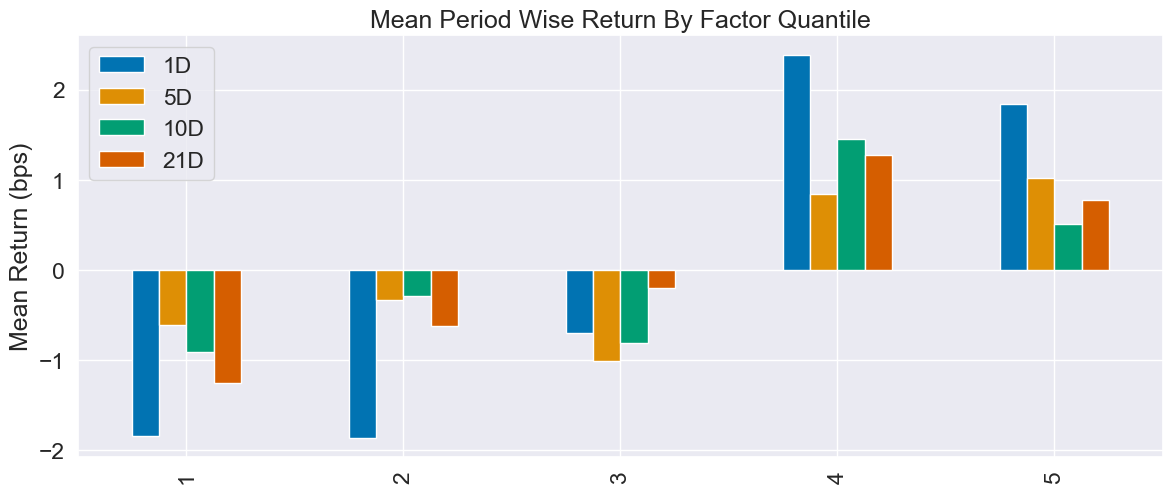

In [ ]:
create_summary_tear_sheet(lr_factor_data);
# 说明可以参考：alphalens入门篇  https://blog.csdn.net/u011331731/article/details/88314459
# 分析结论：短线有点信号，长线更稳，但都不强； turnover 高，费用吃利润，适合当排序信号，不适合单独对冲。

Ridge Regression  岭回归

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73812 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               73812 non-null  float64
 1   5D               73812 non-null  float64
 2   10D              73812 non-null  float64
 3   21D              73812 non-null  float64
 4   factor           73812 non-null  float64
 5   factor_quantile  73812 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.037486,0.010285,-0.003205,0.003644,14982,20.297513
2,-0.011773,0.012590,-0.001242,0.003003,14666,19.869398
3,-0.009860,0.014102,-0.000230,0.003023,14516,19.666179
4,-0.008802,0.016130,0.000739,0.003175,14666,19.869398
5,-0.007385,0.035124,0.002576,0.003867,14982,20.297513


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.048,0.020,0.022,0.020
beta,-0.018,-0.074,-0.065,0.038
Mean Period Wise Return Top Quantile (bps),1.686,0.947,0.353,0.654
Mean Period Wise Return Bottom Quantile (bps),-2.010,-0.639,-1.074,-1.285
Mean Period Wise Spread (bps),3.696,1.612,1.441,1.937


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.017,0.020,0.021
IC Std.,0.179,0.167,0.174,0.156
Risk-Adjusted IC,0.108,0.103,0.114,0.137
t-stat(IC),2.952,2.829,3.110,3.748
p-value(IC),0.003,0.005,0.002,0.000
IC Skew,-0.105,0.011,-0.160,-0.149
IC Kurtosis,-0.175,-0.024,-0.091,-0.244


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.294,0.514,0.619,0.739
Quantile 2 Mean Turnover,0.507,0.697,0.752,0.795
Quantile 3 Mean Turnover,0.554,0.733,0.773,0.804
Quantile 4 Mean Turnover,0.509,0.698,0.757,0.786
Quantile 5 Mean Turnover,0.296,0.520,0.628,0.736


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.822,0.569,0.417,0.247


<Figure size 640x480 with 0 Axes>

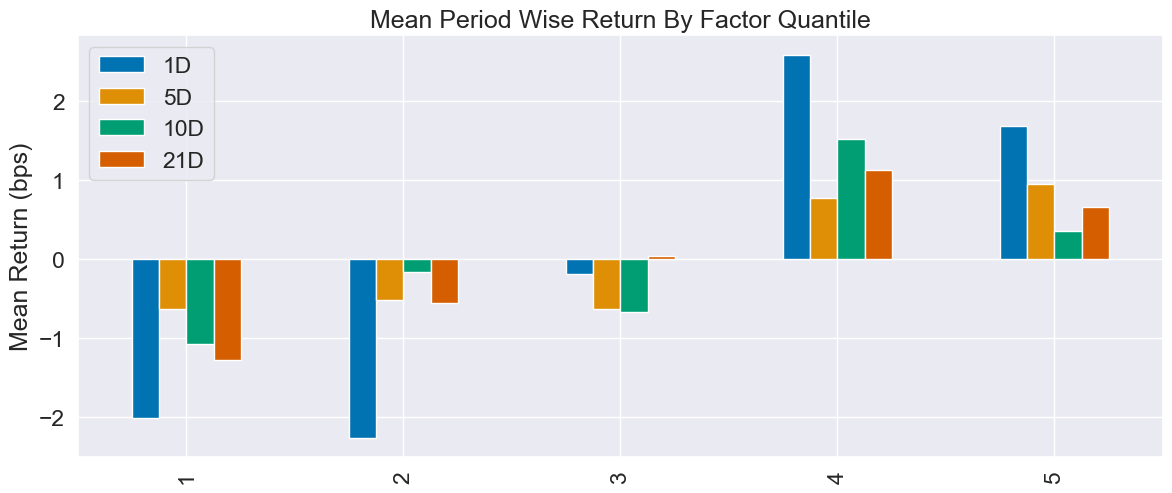

In [20]:
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 5, 10, 21))
ridge_factor_data.info()

create_summary_tear_sheet(ridge_factor_data);

Lasso Regression  套索回归

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73812 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               73812 non-null  float64
 1   5D               73812 non-null  float64
 2   10D              73812 non-null  float64
 3   21D              73812 non-null  float64
 4   factor           73812 non-null  float64
 5   factor_quantile  73812 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.043925,0.010653,-0.003470,0.004004,14982,20.297513
2,-0.013494,0.012950,-0.001383,0.003265,14666,19.869398
3,-0.011373,0.014600,-0.000327,0.003284,14516,19.666179
4,-0.010174,0.016758,0.000706,0.003431,14666,19.869398
5,-0.008641,0.035891,0.002654,0.004164,14982,20.297513


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.048,0.017,0.019,0.020
beta,-0.017,-0.068,-0.058,0.041
Mean Period Wise Return Top Quantile (bps),1.842,1.016,0.514,0.778
Mean Period Wise Return Bottom Quantile (bps),-1.847,-0.613,-0.910,-1.259
Mean Period Wise Spread (bps),3.689,1.652,1.433,2.028


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.017,0.019,0.023
IC Std.,0.178,0.165,0.172,0.156
Risk-Adjusted IC,0.107,0.100,0.111,0.148
t-stat(IC),2.940,2.744,3.053,4.045
p-value(IC),0.003,0.006,0.002,0.000
IC Skew,-0.093,0.031,-0.158,-0.142
IC Kurtosis,-0.212,-0.053,-0.107,-0.231


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.300,0.527,0.630,0.747
Quantile 2 Mean Turnover,0.516,0.705,0.758,0.797
Quantile 3 Mean Turnover,0.560,0.739,0.773,0.807
Quantile 4 Mean Turnover,0.515,0.704,0.756,0.789
Quantile 5 Mean Turnover,0.302,0.530,0.637,0.741


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.817,0.551,0.401,0.236


<Figure size 640x480 with 0 Axes>

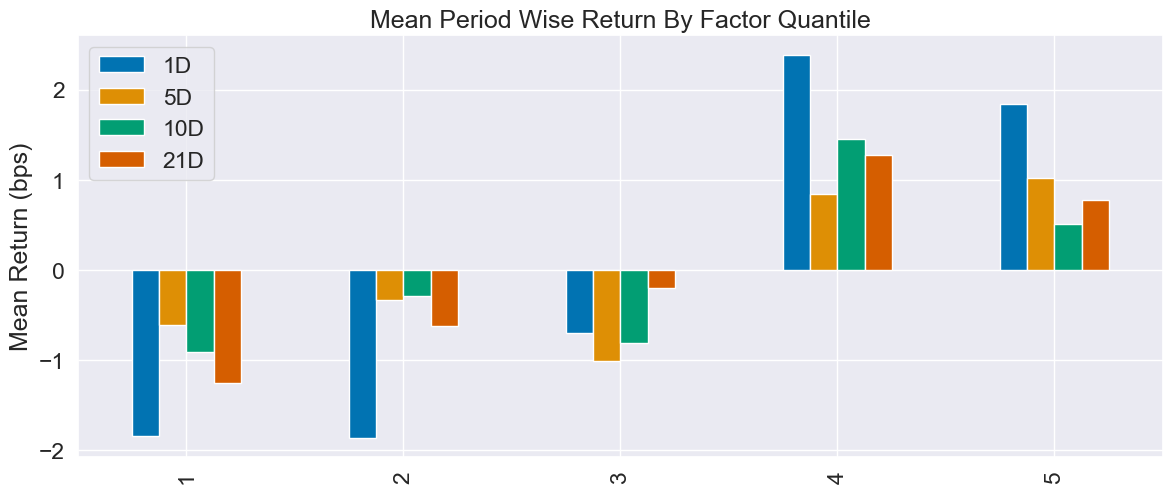

In [21]:
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lasso_factor_data.info()

create_summary_tear_sheet(lasso_factor_data);